# RNA velocity analysis on mouse embryonic fibroblasts

## Library imports

In [1]:
import sys

import pandas as pd

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv
from anndata import AnnData

from cr2 import running_in_notebook

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")
scv.settings.plot_prefix = ""

In [4]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / "realtime_kernel" / "mef").mkdir(parents=True, exist_ok=True)

FIGURE_FORMAT = "pdf"

In [5]:
(DATA_DIR / "mef" / "results").mkdir(parents=True, exist_ok=True)

In [6]:
N_JOBS = 8

## Function definitions

## Data loading

In [7]:
adata = sc.read(DATA_DIR / "mef" / "processed" / "mef_velo.h5ad")
adata

AnnData object with n_obs × n_vars = 236285 × 27998
    obs: 'day', 'MEF.identity', 'Pluripotency', 'Cell.cycle', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'SASP', 'Neural.identity', 'Placental.identity', 'X.reactivation', 'XEN', 'Trophoblast', 'Trophoblast progenitors', 'Spiral Artery Trophpblast Giant Cells', 'Spongiotrophoblasts', 'Oligodendrocyte precursor cells (OPC)', 'Astrocytes', 'Cortical Neurons', 'RadialGlia-Id3', 'RadialGlia-Gdf10', 'RadialGlia-Neurog2', 'Long-term MEFs', 'Embryonic mesenchyme', 'Cxcl12 co-expressed', 'Ifitm1 co-expressed', 'Matn4 co-expressed', '2-cell', '4-cell', '8-cell', '16-cell', '32-cell', 'cell_growth_rate', 'serum', '2i', 'major_cell_sets', 'cell_sets', 'batch'
    uns: 'batch_colors', 'cell_sets_colors', 'day_colors', 'major_cell_sets_colors'
    obsm: 'X_force_directed'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [8]:
adata = adata[adata.obs["serum"] == "True"].copy()

adata.obs["day"] = adata.obs["day"].astype(float)
adata.uns["cell_sets_colors"] = sns.color_palette("colorblind").as_hex()[: len(adata.obs["cell_sets"].cat.categories)]

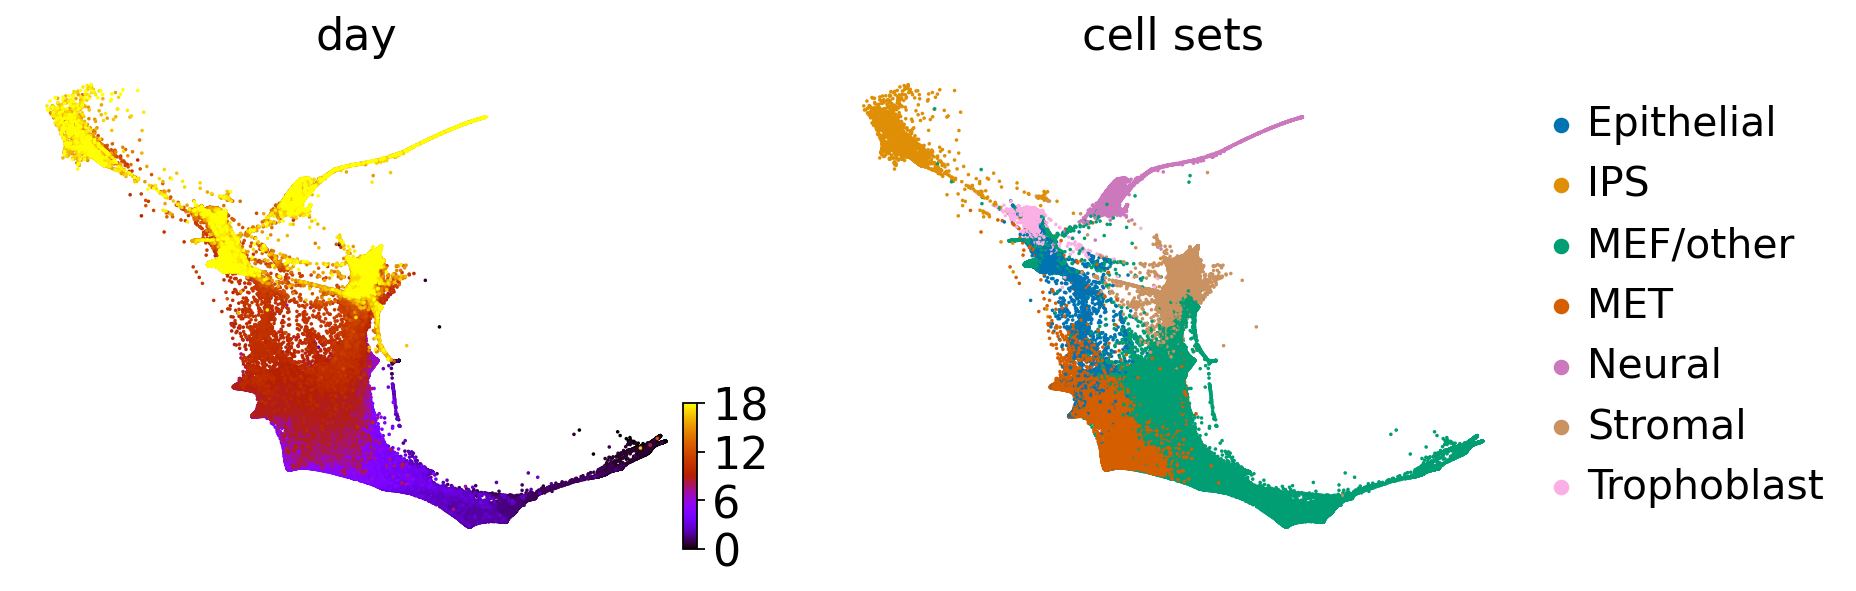

In [9]:
if running_in_notebook():
    scv.pl.scatter(adata, basis="force_directed", c=["day", "cell_sets"], legend_loc="right", cmap="gnuplot")

## Data pre-processing and RNA velocity inference

In [10]:
if (DATA_DIR / "mef" / "results" / "adata_velo_fit.h5ad").is_file():
    adata = sc.read(DATA_DIR / "mef" / "results" / "adata_velo_fit.h5ad")
else:
    scv.pp.filter_and_normalize(adata, min_counts=20, n_top_genes=2000)

    sc.pp.pca(adata)
    sc.pp.neighbors(adata, random_state=0)

    scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

    scv.tl.recover_dynamics(adata, n_jobs=N_JOBS)
    scv.tl.velocity(adata, mode="dynamical")
    adata.write(DATA_DIR / "mef" / "results" / "adata_velo_fit.h5ad", compression="gzip")

## CellRank analysis

### Kernel

In [11]:
vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

Computing transition matrix using `'deterministic'` model


  0%|          | 0/165892 [00:00<?, ?cell/s]

Using `softmax_scale=4.4299`


  0%|          | 0/165892 [00:00<?, ?cell/s]

    Finish (0:01:29)
Computing transition matrix based on `adata.obsp['connectivities']`
DEBUG: Density normalizing the transition matrix
    Finish (0:00:00)


## Estimator

In [12]:
estimator = cr.estimators.GPCCA(combined_kernel)

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[6, 13]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:11)


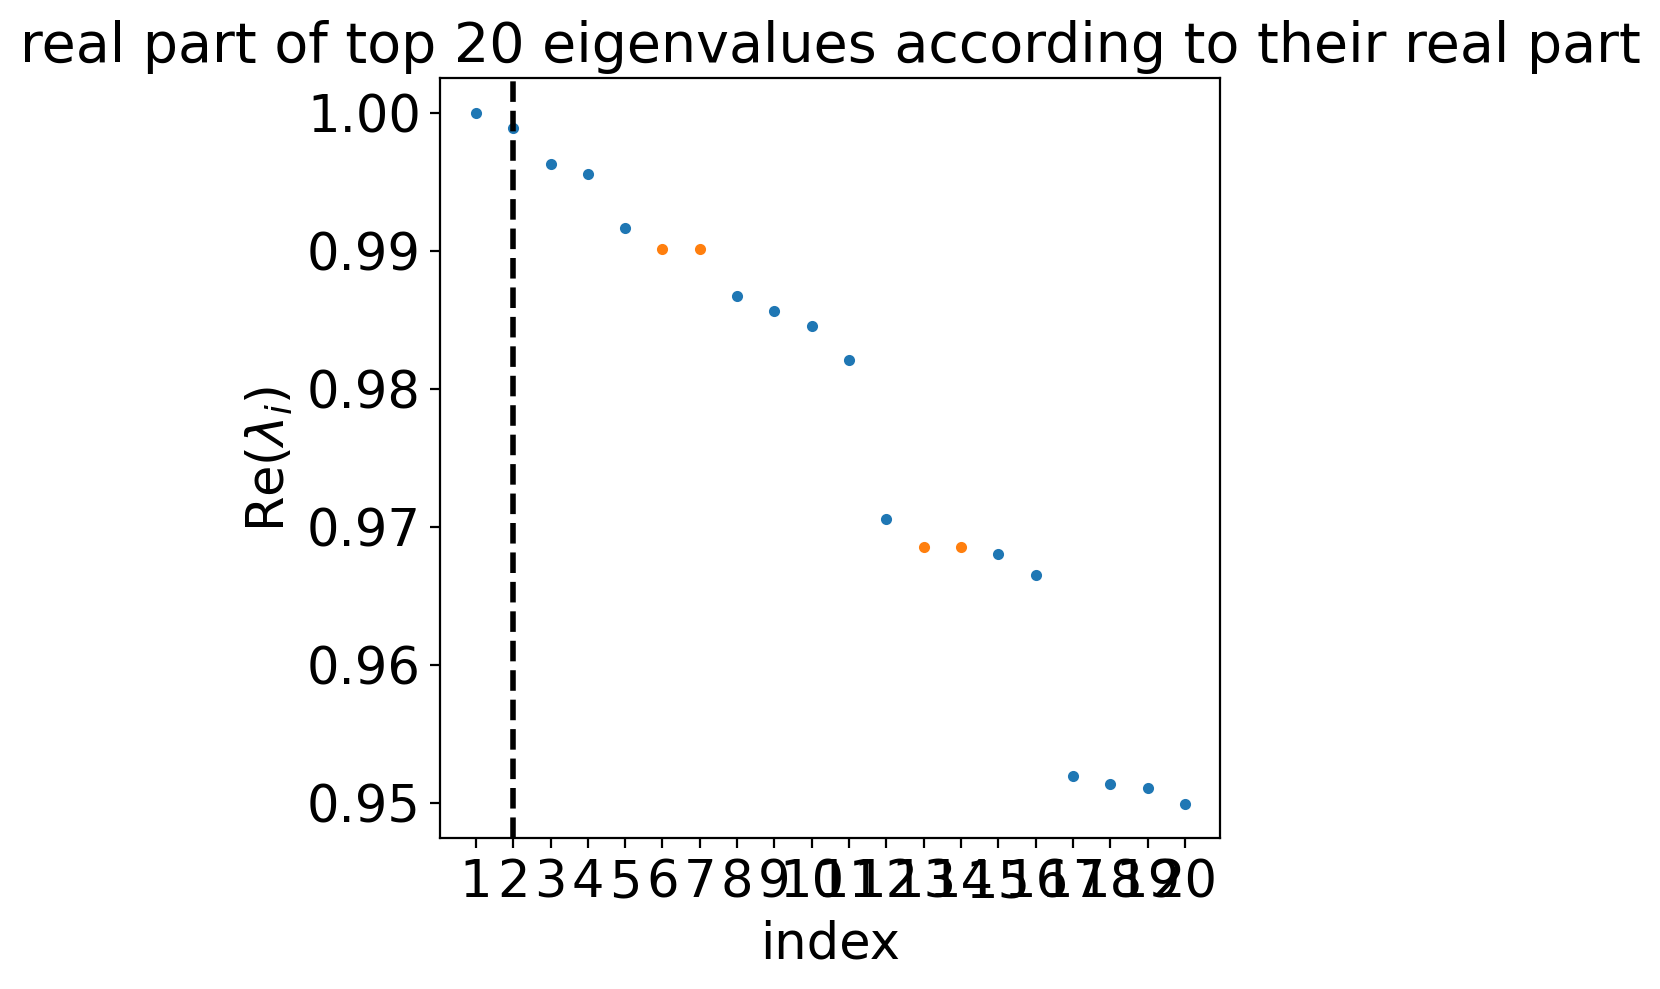

In [13]:
estimator.compute_schur(n_components=20)
estimator.plot_spectrum(real_only=True)

In [14]:
terminal_states = ["Neural", "IPS", "Trophoblast", "Stromal"]
cluster_key = "cell_sets"

if (DATA_DIR / "mef" / "results" / "tsi-vk.csv").is_file():
    tsi_df = pd.read_csv(DATA_DIR / "mef" / "results" / "tsi-vk.csv")
    estimator._tsi = AnnData(tsi_df, uns={"terminal_states": terminal_states, "cluster_key": cluster_key})
    tsi_score = estimator.tsi(n_macrostates=10, terminal_states=terminal_states, cluster_key=cluster_key)
else:
    tsi_score = estimator.tsi(n_macrostates=10, terminal_states=terminal_states, cluster_key=cluster_key)
    estimator._tsi.to_df().to_csv(DATA_DIR / "mef" / "results" / "tsi-vk.csv", index=False)

print(f"TSI score: {tsi_score:.2f}")

TSI score: 0.79


/vol/storage/miniconda3/envs/cr2-py38/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


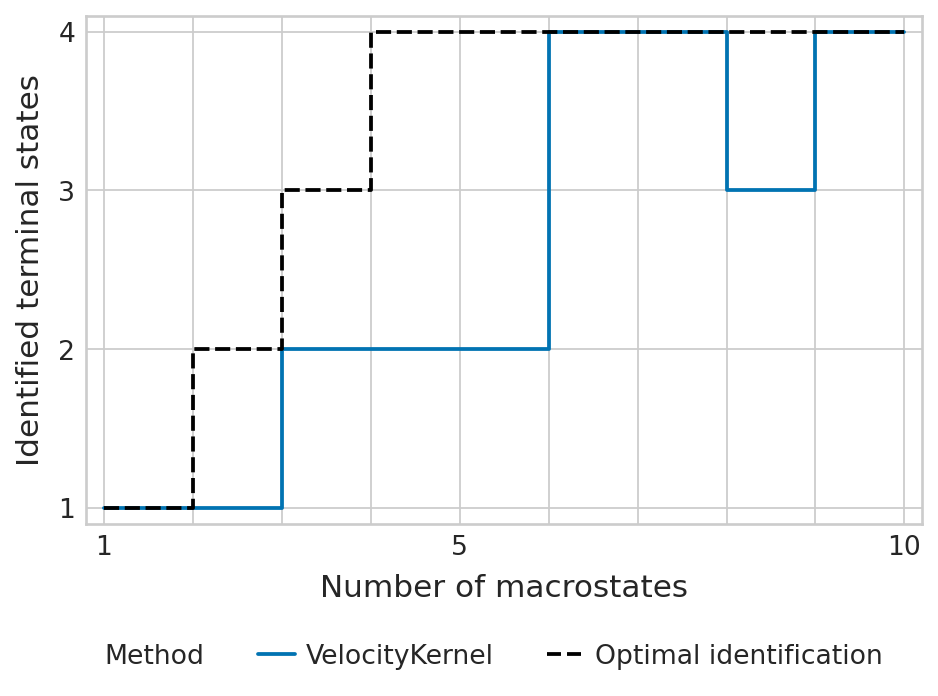

In [15]:
# For nice name in figure legend
estimator.kernel.__class__.__name__ = "VelocityKernel"
palette = {"VelocityKernel": "#0173b2", "Optimal identification": "#000000"}

if SAVE_FIGURES:
    fpath = FIG_DIR / "realtime_kernel" / "mef" / f"tsi-vk.{FIGURE_FORMAT}"
else:
    fpath = None

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    estimator.plot_tsi(palette=palette, save=fpath)
    plt.show()